In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pandas.api.types import CategoricalDtype

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/usr/local/python/lib/python3.10/site-packages/osmnx/utils.py:192: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  warnings.warn(


## Config notebook

In [2]:
#---------- CHOOSE MUNICIPALITIES TO ANALISE (CVEGEO) ----------
cvegeo_list = ['08019','08038','08045',
               '08004','08055',
              '08054','08002']
#08019 - Chihuahua municipality ('Paso del Norte y 'Nuevas Delicias')
#08038 y 08045 - Julimes + Meoqui municipalities ('La Regina')
#08055 (Rosales) and 08004 (Aquiles Serdán) connect 'La Regina' with 'Paso del Norte' and 'Nueva Delicias' in case there is a reason for the whole network to be connected.
#08054 (Riva Palacio) and 08002 (Aladama) must be added when calculating proximity to emergency equipment in 'Nuevas Delicias'

#08051 - Ocampo municipality ('Basaseachi') is isolated and does not have a network

#---------- SPECIFY AMENITY NAME CURRENTLY ANALIZED ----------
a = str('asistenciasocial') #a is the name of the amenity currently examined
current_data = "../../../data/external/temporal_todocker/proximity_pois_asistenciasocial.gpkg" #georeferenced file with points of interest
correction = False #ONLY IF updating previously calculated proximity for specific amenity
savetodb = True #Save to Data Base?

## Data download

<Axes: >

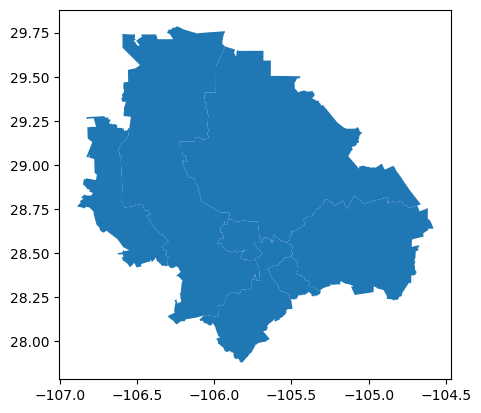

In [3]:
#Query municipalities
mun_schema = 'marco'
mun_table = 'mpos_2020'

mun_gdf = gpd.GeoDataFrame()
# Iterates over municipality codes for each metropolitan area or capital
for cvegeo in cvegeo_list:
    # Downloads municipality polygon according to code
    query = f"SELECT * FROM {mun_schema}.{mun_table} WHERE \"CVEGEO\" LIKE \'{cvegeo}%%\'"
    mun_tmp = aup.gdf_from_query(query, geometry_col='geometry')
    mun_gdf = pd.concat([mun_gdf, mun_tmp],
    ignore_index = True, axis = 0)

#Define projections and plot
mun_gdf = mun_gdf.set_crs("EPSG:4326")
mun_gdf.plot()

In [4]:
#Load points of interest and filter for relevant data
pois = gpd.read_file(current_data)
points = pois[['geometry']]

#Review result
print(points.shape)
points.head(2)

(22, 1)


,geometry
0,POINT (-106.15315 28.73113)
1,POINT (-106.15337 28.73101)


## Proximity analysis

### Proximity analysis - 01 Find closest osmnx node to each point of interest

Create network

In [5]:
G, nodes, edges = aup.graph_from_hippo(mun_gdf, 'osmnx')

In [6]:
points = points.set_crs("EPSG:4326")
nodes = nodes.set_crs("EPSG:4326")
edges = edges.set_crs("EPSG:4326")

Find nearest node for each point (Returns points gdf with osmid and distance info)

In [7]:
nearest = aup.find_nearest(G, nodes, points, return_distance= True)
nearest = nearest.set_crs("EPSG:4326")

In [8]:
#Review result
print(nearest.shape)
nearest.head(2)

(22, 3)


,geometry,osmid,distance_node
0,POINT (-106.15315 28.73113),3638038378,37.929076
1,POINT (-106.15337 28.73101),3638038379,32.804570


### Proximity analysis - 02 Find min distance from nodes to points of interest (previously assigned node)

Data treatment for nodes and edges

In [9]:
#Nodes: Reset index
nodes_analysis = nodes.reset_index().copy()

#Nodes: Create df_temp, each column will be a batch of procesed nodes.
df_temp = nodes.copy()

#Nodes: Create nodes_distance. Minimum time/lenght found in all batches will be added from df_min to nodes_distance.
nodes_distance = nodes.copy()

Find distance to nearest point

In [10]:
#Set batch size
batches = len(nearest)/250

for k in range(int(batches)+1):
            
            #Divide points in batches
            points_process = nearest.iloc[int(250*k):int(250*(1+k))].copy()
            
            #Calculate the distance of each node to currently examined amenity
            nodes_distance_prep = aup.calculate_distance_nearest_poi(points_process, nodes_analysis, 
            edges, a, 'osmid', wght='length')
            
            #A middle gdf is created whose columns will be the name of the amenity and the group number it belongs to
            df_int = pd.DataFrame()
            df_int['dist'+str(k)+a] = nodes_distance_prep['dist_'+a]
            
            #The middle gdf is merged into the previously created temporary gdf to store the data
            df_temp = df_temp.merge(df_int, left_index=True, right_index=True)

#Drop the non-distance values from the temporary gdf
df_temp.drop(['x', 'y', 'street_count','geometry'], inplace = True, axis=1)

#Review result
print(df_temp.shape)
df_temp.head(2)

(70805, 1)


,dist0emergencia
osmid,
230565134,769.332
230565138,2649.117


Find minimum value of all batches

In [11]:
df_min = pd.DataFrame()
df_min['dist_'+a] = df_temp.min(axis=1)
df_min.head()

,dist_emergencia
osmid,
230565134,769.332
230565138,2649.117
230565140,3157.073
230579435,473.210
230605901,1979.548


Add minimum value to nodes (nodes_distance)

In [12]:
nodes_distance = nodes_distance.merge(df_min, left_index=True, right_index=True)
nodes_distance.head(2)

,x,y,street_count,geometry,dist_emergencia
osmid,,,,,
230565134,-106.147366,28.728815,3,POINT (-106.14737 28.72881),769.332
230565138,-106.110401,28.687995,3,POINT (-106.11040 28.68799),2649.117


Convert distance to time data (Walking speed = 4km/hr)

In [13]:
nodes_time = nodes_distance.copy()
nodes_time['time_'+a] = (nodes_time['dist_'+a]*60)/4000
nodes_time.head(2)

,x,y,street_count,geometry,dist_emergencia,time_emergencia
osmid,,,,,,
230565134,-106.147366,28.728815,3,POINT (-106.14737 28.72881),769.332,11.539980
230565138,-106.110401,28.687995,3,POINT (-106.11040 28.68799),2649.117,39.736755


### Proximity analysis - 03 Join data with existing data

Create nodes_amenities from formated nodes_distance

In [14]:
nodes_time.reset_index(inplace=True)
nodes_amenities = nodes_time[['osmid','x','y','geometry','time_'+a]]
nodes_amenities = nodes_amenities.set_crs("EPSG:4326")

print(nodes_amenities.shape)
nodes_amenities.head(2)

(70805, 5)


,osmid,x,y,geometry,time_emergencia
0,230565134,-106.147366,28.728815,POINT (-106.14737 28.72881),11.539980
1,230565138,-106.110401,28.687995,POINT (-106.11040 28.68799),39.736755


Add municipality info

In [15]:
#Overlay with mun_gdf
municipalities = mun_gdf[['NOMGEO','geometry']]
nodes_amenities = nodes_amenities.overlay(municipalities)

#Change column name to mun
nodes_amenities.rename(columns={'NOMGEO':'mun'},inplace=True)

print(nodes_amenities.shape)
nodes_amenities.head(2)

(70688, 6)


,osmid,x,y,time_emergencia,mun,geometry
0,230565134,-106.147366,28.728815,11.539980,Chihuahua,POINT (-106.14737 28.72881)
1,230565138,-106.110401,28.687995,39.736755,Chihuahua,POINT (-106.11040 28.68799)


Join currently examined nodes with previously examined nodes

In [16]:
mun_schema = 'projects_research'
mun_table = 'nodes_proximity_dfv_test'

query = f"SELECT * FROM {mun_schema}.{mun_table}"
nodes_proximity_dfv = aup.gdf_from_query(query, geometry_col='geometry')

print(nodes_proximity_dfv.shape)
nodes_proximity_dfv.head(2)

(65724, 10)


,osmid,time_salud,time_guarderias,time_asistenciasocial,time_espaciopublico,time_terminales,mun,x,y,geometry
0,230565134,14.854920,8.709600,164.560920,5.328240,4.946715,Chihuahua,-106.147366,28.728815,POINT (-106.14737 28.72881)
1,230565138,8.552025,7.431015,77.356365,5.196495,36.944310,Chihuahua,-106.110401,28.687995,POINT (-106.11040 28.68799)


In [17]:
nodes_amenities_mun =gpd.GeoDataFrame()

for municipality in nodes_amenities.mun.unique():
    #Current analyisis in current mun
    nodes_amenities_currentmun = nodes_amenities.loc[nodes_amenities.mun == municipality]
    
    #If municipality already exists in database, merge on osmid. Else, concat new data
    if municipality in nodes_proximity_dfv.mun.unique(): 
        #Existing data in current mun
        nodes_proximity_dfv_currentmun = nodes_proximity_dfv.loc[nodes_proximity_dfv.mun == municipality]
        
        #Join current mun data
        nodes_amenities_currentmun = nodes_proximity_dfv_currentmun.merge(nodes_amenities_currentmun[['osmid','time_'+a]], on='osmid',how='outer')
        nodes_amenities_currentmun = nodes_amenities_currentmun.set_crs("EPSG:4326")
        
        #Join current mun with all muns
        nodes_amenities_mun = pd.concat([nodes_amenities_mun,nodes_amenities_currentmun])
        
    else:
        #Join current mun with all muns
        nodes_amenities_mun = pd.concat([nodes_amenities_mun,nodes_amenities_currentmun])        

#Review results
print(nodes_amenities_mun.shape)
nodes_amenities_mun.head(2)

(70688, 11)


,osmid,time_salud,time_guarderias,time_asistenciasocial,time_espaciopublico,time_terminales,mun,x,y,geometry,time_emergencia
0,230565134,14.854920,8.709600,164.560920,5.328240,4.946715,Chihuahua,-106.147366,28.728815,POINT (-106.14737 28.72881),11.539980
1,230565138,8.552025,7.431015,77.356365,5.196495,36.944310,Chihuahua,-106.110401,28.687995,POINT (-106.11040 28.68799),39.736755


In [18]:
if correction:
    nodes_amenities_mun.drop(columns='time_{}_x'.format(a),inplace=True)
    nodes_amenities_mun.rename(columns={'time_{}_y'.format(a):'time_{}'.format(a)},inplace=True)

print(nodes_amenities_mun.shape)
nodes_amenities_mun.head(2)

(70688, 11)


,osmid,time_salud,time_guarderias,time_asistenciasocial,time_espaciopublico,time_terminales,mun,x,y,geometry,time_emergencia
0,230565134,14.854920,8.709600,164.560920,5.328240,4.946715,Chihuahua,-106.147366,28.728815,POINT (-106.14737 28.72881),11.539980
1,230565138,8.552025,7.431015,77.356365,5.196495,36.944310,Chihuahua,-106.110401,28.687995,POINT (-106.11040 28.68799),39.736755


Format

In [19]:
#Find current available columns
cols = nodes_amenities_mun.columns.tolist()

#Remove base columns to reorder
cols.remove('x')
cols.remove('y')
cols.remove('geometry')
cols.remove('mun')

#Add base columns to reorder
cols.append('mun')
cols.append('x')
cols.append('y')
cols.append('geometry')

#Save new order
nodes_format = nodes_amenities_mun[cols]

#Review result
print(nodes_format.shape)
nodes_format.head(2)

(70688, 11)


,osmid,time_salud,time_guarderias,time_asistenciasocial,time_espaciopublico,time_terminales,time_emergencia,mun,x,y,geometry
0,230565134,14.854920,8.709600,164.560920,5.328240,4.946715,11.539980,Chihuahua,-106.147366,28.728815,POINT (-106.14737 28.72881)
1,230565138,8.552025,7.431015,77.356365,5.196495,36.944310,39.736755,Chihuahua,-106.110401,28.687995,POINT (-106.11040 28.68799)


In [20]:
nodes_proximity_dfv = gpd.GeoDataFrame(nodes_format, geometry='geometry')

Save to db

In [27]:
if savetodb:
    aup.gdf_to_db_slow(nodes_proximity_dfv,'nodes_proximity_dfv_test','projects_research',if_exists="replace")

Exception during reset or similar
Traceback (most recent call last):
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 991, in _finalize_fairy
    fairy._reset(
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/pool/base.py", line 1440, in _reset
    pool._dialect.do_rollback(self)
  File "/usr/local/python/lib/python3.10/site-packages/sqlalchemy/engine/default.py", line 657, in do_rollback
    dbapi_connection.rollback()
psycopg2.OperationalError: server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.
server closed the connection unexpectedly
	This probably means the server terminated abnormally
	before or while processing the request.



### Corrección de un osmid errante

In [39]:
#for osmid in nodes_proximity_dfv.osmid.unique(): #Previous faulty osmid:7375150468
#    if osmid not in nodes_amenities.osmid.unique():
#        print(osmid)

7375150468


In [42]:
#nodes_proximity_dfv.loc[nodes_proximity_dfv.osmid==7375150468]

,osmid,time_salud,time_guarderias,time_asistenciasocial,time_espaciopublico,time_terminales,mun,x,y,geometry


In [41]:
#nodes_proximity_dfv.drop(index=1762,inplace=True)

In [43]:
#print(nodes_proximity_dfv.shape)
#nodes_proximity_dfv.head(2)

(65722, 10)


,osmid,time_salud,time_guarderias,time_asistenciasocial,time_espaciopublico,time_terminales,mun,x,y,geometry
0,230565134,14.854920,8.709600,164.560920,5.328240,4.946715,Chihuahua,-106.147366,28.728815,POINT (-106.14737 28.72881)
1,230565138,8.552025,7.431015,77.356365,5.196495,36.944310,Chihuahua,-106.110401,28.687995,POINT (-106.11040 28.68799)
